<a href="https://colab.research.google.com/github/ka-means/Recommender-systems/blob/main/Recommender_System_Using_Collaborative_Filtering_and_Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta sesión de trabajo, nos centraremos en el estudio práctico de los sistemas de recomendación, utilizando como base el dataset de MovieLens y la biblioteca de Python, Surprise. Nuestro objetivo será comprender y aplicar dos técnicas fundamentales en el ámbito de las recomendaciones: filtrado colaborativo basado en usuarios (UserKNN) y en ítems (ItemKNN), además de explorar el método FunkSVD para la descomposición de matrices.

In [ ]:
!pip install numpy==1.24.3

  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.3.3 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.24.3 which is incompatible.
blosc2 3.7.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
pywavelets 1.9.0 requires numpy<3,>=1.25, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompat

## Preparación del Entorno y Descarga de Datos

Antes de comenzar con el análisis y la construcción de modelos de recomendación, necesitamos preparar nuestro entorno de trabajo e importar los datos que utilizaremos.

### Instalación de Paquetes Necesarios

Para asegurarnos de que tenemos todas las herramientas necesarias, instalaremos los paquetes `wget` y `zipfile36`. Estos nos permitirán descargar y extraer el dataset de MovieLens directamente desde su fuente oficial.


In [ ]:
!pip install wget
!pip install zipfile36
!python3 -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


Saved under ml-100k (2).zip


In [ ]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [ ]:
train_dir = "ml-100k/u2.base"
test_dir = "ml-100k/u2.test"



## Carga y Exploración Inicial de los Datos

Una vez descargado el dataset, el siguiente paso es cargar los datos en nuestro entorno de trabajo para comenzar la exploración y análisis preliminar. Para ello, utilizaremos las bibliotecas `pandas` para la manipulación de datos y `matplotlib` para la visualización.

### Importación de Bibliotecas Necesarias

Primero, importamos las bibliotecas `pandas` y `matplotlib`, que serán esenciales para el manejo de datos y la generación de gráficos respectivamente.

## Carga de Datos generales

Utilizamos pandas para cargar el dataset de calificaciones. Especificamos el separador de columnas (\t, ya que el archivo está tabulado), los nombres de las columnas para una mejor comprensión del dataset, y establecemos que el archivo no tiene fila de encabezado (header=None).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

ratings = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

ratings.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


## Carga y Preparación de Datos de Películas

Tras haber cargado y revisado los datos de calificaciones, el siguiente paso es integrar información adicional sobre las películas para enriquecer nuestro análisis. Esto incluye detalles como el título, fecha de lanzamiento, género, entre otros.

Primero, definimos una lista con los nombres de las columnas que esperamos encontrar en el dataset de películas. Esto nos ayudará a mantener la claridad y consistencia en el manejo de datos.

A continuación, cargamos el dataset de películas. Usamos el encoding 'latin-1' para asegurar la correcta lectura de caracteres especiales. Asignamos el índice basándonos en la columna movieid y luego reseteamos el índice para facilitar el manejo de los datos. También renombramos la columna movieid a itemid para mantener consistencia con el dataset de calificaciones.

In [ ]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

movies = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, encoding='latin-1').reset_index()
movies = movies.rename(columns={'movieid': 'itemid'})
movies.head()

,itemid,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['release_date'] = movies['release_date'].dt.year
movies['release_date'].isnull().sum()

1

In [ ]:
movies.dropna(subset=['release_date'] , inplace=True)
movies.head()

,itemid,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
print ( 'min year:' , movies['release_date'].min() , ' |  max year:', movies['release_date'].max())

min year: 1922.0  |  max year: 1998.0


In [ ]:
avg_ratings = ratings[['itemid' , 'rating']].groupby('itemid').mean().round(2)
movies = movies.merge(avg_ratings, how='inner', on='itemid')
movies.head(4)

,itemid,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.89
1,2,GoldenEye (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.28
2,3,Four Rooms (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.02
3,4,Get Shorty (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,3.53


Este bloque de código filtra las películas lanzadas después de 1950 y luego explora la relación entre la fecha de lanzamiento de las películas, sus calificaciones promedio, y el número de películas lanzadas por año. Al principio, se crea una máscara (year_mask) para filtrar las películas según su fecha de lanzamiento, enfocándose solo en aquellas después de 1950, lo cual es crucial para concentrar el análisis en un período más relevante y posiblemente más rico en datos. Después, se aplican operaciones de agrupación y cálculo de estadísticas: se calcula la calificación promedio (y1) y se cuenta el número de títulos (y2) por año, permitiendo así identificar tendencias sobre cómo han cambiado las preferencias del público y la industria del cine a lo largo del tiempo.

La visualización se realiza mediante dos subgráficos: el primero muestra las calificaciones promedio de las películas a lo largo de los años (ax1) y el segundo el número de películas lanzadas por año (ax2), compartiendo el eje X (año). Este enfoque de visualización doble es esencial para proporcionar una comparación directa de cómo la cantidad de películas y sus calificaciones promedio evolucionan simultáneamente, ofreciendo insights sobre posibles correlaciones entre el volumen de producción de películas y su calidad percibida a lo largo del tiempo. La configuración detallada de la visualización, incluyendo colores, títulos y límites de eje, mejora la claridad y la interpretación de los datos, haciendo esta etapa crítica para la comprensión y comunicación de tendencias clave en la industria del cine.

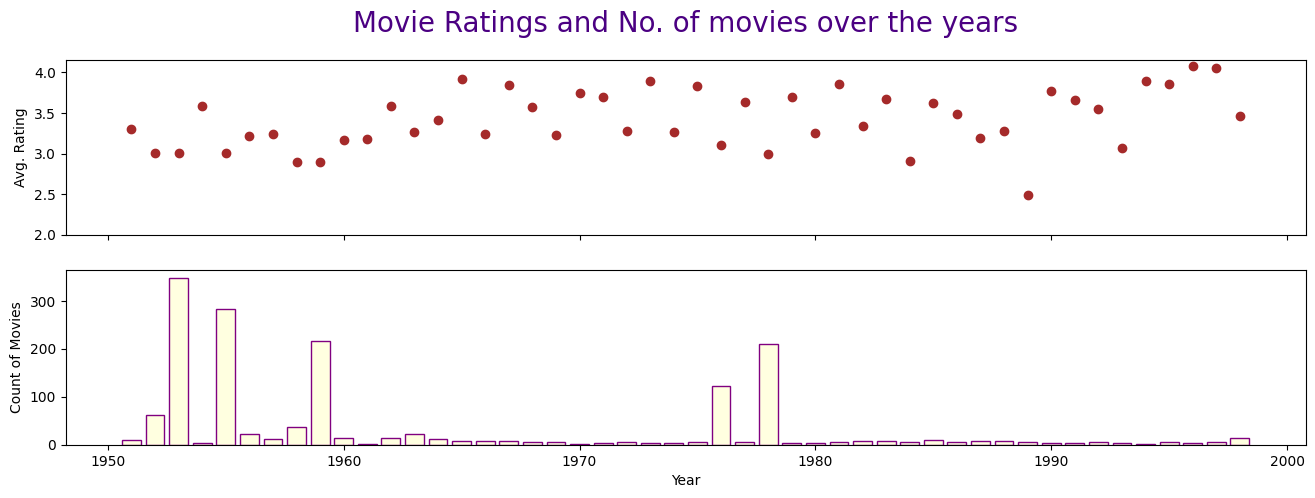

In [ ]:
year_mask = movies['release_date'] > 1950

movies_after_1950 = movies[year_mask]

movies_after_1950.head()

x = movies_after_1950['release_date'].unique()

y1 = movies_after_1950[['release_date','rating']].groupby('release_date').mean()

y2 = movies_after_1950[['release_date','title']].groupby('release_date').count()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,5), sharex=True)

ax1.set_title('Movie Ratings and No. of movies over the years', loc = 'center' , pad = 20 , fontdict={'fontsize':20 , 'color' : 'indigo',
#                                                                                  'fontstyle' : 'italic',
                                                                                'fontfamily' : 'Tahoma'})
ax1.scatter(x,y1,color='brown')
ax1.set_ylabel('Avg. Rating')
ax1.set_ylim(2,)

ax2.bar( x, y2.title.values,  color = 'lightyellow', label=True, edgecolor = 'purple' )
ax2.set_ylabel('Count of Movies')
ax2.set_xlabel('Year')

plt.show()

In [ ]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
ratings.rename(columns={'timestamp' : 'ratings_year'} , inplace=True)


Este código calcula y muestra las 25 películas con el mayor número de calificaciones en el dataset, lo que proporciona una visión clara de cuáles son los títulos más populares o discutidos entre los usuarios. Inicialmente, se agrupan las calificaciones por itemid (que representa la película) y se cuentan los usuarios que han calificado cada película, lo cual se almacena en count_of_ratings.

In [ ]:

count_of_ratings = ratings[['itemid' , 'userid']].groupby('itemid').count()
count_of_ratings.rename(columns={'userid' : 'Count of Ratings'}, inplace=True)

movie_rating_counts = movies[['itemid','title']].merge(count_of_ratings, on='itemid')

movie_rating_counts.sort_values('Count of Ratings' , ascending=False)[:25] [['title' , 'Count of Ratings']]

,title,Count of Ratings
49,Star Wars (1977),461
99,Fargo (1996),414
257,Contact (1997),409
180,Return of the Jedi (1983),406
292,Liar Liar (1997),402
284,"English Patient, The (1996)",397
286,Scream (1996),360
0,Toy Story (1995),358
120,Independence Day (ID4) (1996),351
298,Air Force One (1997),345


In [ ]:
movies = movies.merge(movie_rating_counts[['itemid' , 'Count of Ratings']])
movies[movies['Count of Ratings'] > 300].sort_values('rating', ascending=False)[:10]

,itemid,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,Count of Ratings
49,50,Star Wars (1977),1977.0,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,4.36,461
126,127,"Godfather, The (1972)",1972.0,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4.30,332
173,174,Raiders of the Lost Ark (1981),1981.0,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.26,336
97,98,"Silence of the Lambs, The (1991)",1991.0,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,4.26,314
171,172,"Empire Strikes Back, The (1980)",1980.0,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,4.21,309
99,100,Fargo (1996),1997.0,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,4.17,414
55,56,Pulp Fiction (1994),1994.0,NaN,http://us.imdb.com/M/title-exact?Pulp%20Fictio...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,4.03,308
180,181,Return of the Jedi (1983),1997.0,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,3.99,406
0,1,Toy Story (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.89,358
6,7,Twelve Monkeys (1995),1995.0,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3.81,318


[Text(0.5, 1.0, 'Número de interacciones por usuario'),
 Text(0.5, 0, 'Cantidad de items'),
 Text(0, 0.5, 'Cantidad de usuarios')]

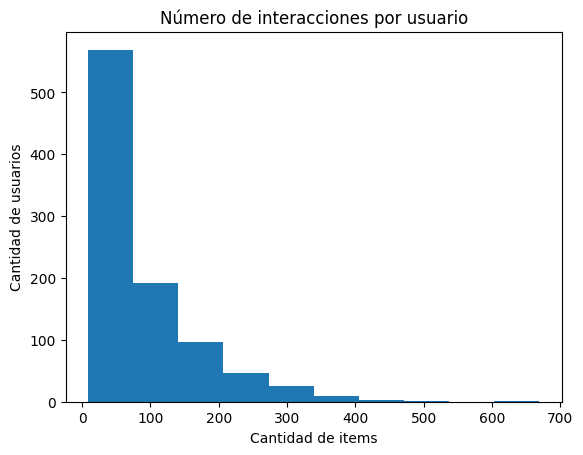

In [ ]:
import matplotlib.pyplot as plt

distrib = ratings.groupby(['userid']).count().sort_values(by=['itemid'], ascending=False)
x = distrib['itemid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por usuario', xlabel='Cantidad de items', ylabel='Cantidad de usuarios')

[Text(0.5, 1.0, 'Número de interacciones por item'),
 Text(0.5, 0, 'Cantidad de interacciones'),
 Text(0, 0.5, 'Numero de items')]

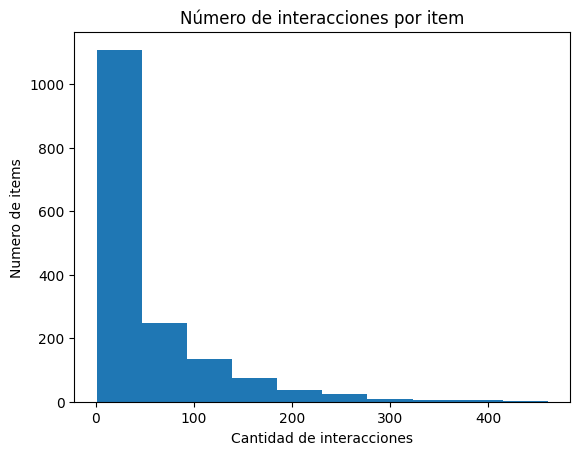

In [ ]:
distrib_item = ratings.groupby(['itemid']).count().sort_values(by=['userid'], ascending=False)
x = distrib_item['userid']
plt.hist(x)
plt.gca().set(title='Número de interacciones por item', xlabel='Cantidad de interacciones', ylabel='Numero de items')

In [ ]:
# Ver la o las filas específicas del usuario con 201
ratings[ratings['userid'] == 201]

,userid,itemid,rating,ratings_year
14830,201,1,3,1998
14831,201,2,2,1998
14832,201,4,4,1998
14833,201,7,3,1998
14834,201,8,3,1998
...,...,...,...,...
15122,201,1423,3,1998
15123,201,1424,3,1998
15124,201,1425,3,1998
15125,201,1426,2,1998


##Recomendacion

In [ ]:
!pip install scikit-surprise

  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version

In [ ]:
#los 4 fantasticos, la sustancia, emilia perez, flow, conclave

#userknn

#nicolas = [5,5,1,4,0]
#raquel = [2,2,1,0,0]
#rene = [0,0,5,0,0]
#eleazar = [2,2,0,1,0]
#sara = [5,5,1,0,0]

# item knn

#los 4 fantasticos = [5,2,0,2,5]
#la sustancia = [5,2,0,2,5]
#emilia perez = [1,1,5,2,1]


In [ ]:
import surprise
print(surprise.__version__)

from surprise.model_selection import PredefinedKFold
from collections import defaultdict

1.1.4


`reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5)): `La primera línea crea un objeto Reader de Surprise, el cual es necesario para interpretar el formato de los datos del archivo de calificaciones. Se especifica el formato de línea con line_format, indicando que cada línea del archivo contiene información del usuario, el ítem, la calificación, y el timestamp, en ese orden. El separador sep='\t' indica que los datos están separados por tabulaciones, y rating_scale=(1,5) define el rango de las calificaciones, que en este caso varía de 1 a 5.

`data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader): `La segunda línea carga el conjunto de datos desde archivos de entrenamiento y prueba especificados por train_dir y test_dir, respectivamente, utilizando el formato definido por el Reader previamente creado. Esto es crucial para asegurar que los datos se carguen correctamente en la estructura requerida por Surprise para su posterior análisis.

`pkf = PredefinedKFold(): `Finalmente, se inicializa un objeto PredefinedKFold de Surprise, que se usa para realizar validación cruzada con conjuntos de entrenamiento y prueba ya definidos, en lugar de dividir aleatoriamente el conjunto de datos. Esto es especialmente útil cuando se tienen conjuntos de datos específicos sobre los que se desea evaluar el rendimiento del modelo. Al llamar a next(pkf.split(data)), se obtienen el conjunto de entrenamiento y el conjunto de prueba que se utilizarán para entrenar y evaluar el modelo, respectivamente. Este paso es esencial para proceder con la experimentación de modelos de recomendación, permitiendo una evaluación precisa y controlada del rendimiento del modelo en datos no vistos, lo cual es fundamental para comprender su capacidad de generalización y hacer ajustes antes de su implementación real.








In [ ]:
train_dir = "ml-100k/u2.base"
test_dir = "ml-100k/u2.test"

In [ ]:
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

In [ ]:
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

In [ ]:
myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
myUserKnn.predict(uid = "457", iid = "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.161717349048707, details={'actual_k': 6, 'was_impossible': False})

Este fragmento de código está diseñado para generar predicciones de calificaciones para pares usuario-ítem que no están presentes en el conjunto de entrenamiento, utilizando un modelo de filtrado colaborativo basado en los k vecinos más cercanos para usuarios (UserKNN) ya entrenado.

`trainset.build_anti_testset():` Este método crea un "anti-testset", que es un conjunto de todas las posibles combinaciones de usuarios e ítems que no tienen calificaciones en el conjunto de entrenamiento original. Este conjunto es útil para predecir calificaciones de ítems que un usuario aún no ha calificado, lo cual es una parte esencial de generar recomendaciones en sistemas de filtrado colaborativo. Esencialmente, permite evaluar cómo el modelo podría prever las preferencias de los usuarios por ítems que no han interactuado previamente, lo cual es una faceta crítica de los sistemas de recomendación: sugerir nuevos ítems que los usuarios podrían encontrar interesantes.

`predictions = myUserKnn.test(a_testset):` Una vez generado el anti-testset, este se pasa al método test del modelo myUserKnn, que es una instancia previamente entrenada del modelo UserKNN de la biblioteca Surprise. El método test utiliza el modelo para predecir las calificaciones para cada par usuario-ítem en el anti-testset. El resultado es una lista de predicciones que contiene, para cada par usuario-ítem en el anti-testset, la calificación predicha por el modelo. Este paso es clave para generar recomendaciones personalizadas, ya que las predicciones pueden ser utilizadas para recomendar a cada usuario los ítems con las calificaciones más altas predichas, es decir, aquellos ítems que el modelo considera que el usuario valoraría positivamente basándose en las preferencias implícitas capturadas a través de las interacciones con otros ítems y las interacciones de usuarios similares.

In [ ]:
import pandas as pd
from itertools import product

# Items
items = ["anora", "la_sustancia", "emilia_perez", "flow", "conclave"]

# Matriz de calificaciones (0 = no calificado)
ratings_dict = {
    "nicolas": [5, 5, 1, 4, 0],
    "raquel":  [2, 2, 1, 0, 0],
    "rene":    [0, 0, 5, 0, 0],
    "eleazar": [2, 2, 0, 1, 0],
    "sara":    [5, 5, 1, 0, 0]
}

ratings_df = pd.DataFrame(ratings_dict, index=items).T
print("📊 Matriz de calificaciones:\n")
display(ratings_df)

# Construir anti-test set: pares usuario-ítem con rating 0
anti_test_set = []
for user, row in ratings_df.iterrows():
    for item, rating in row.items():
        if rating == 0:
            anti_test_set.append((user, item))

print("\n📋 Anti-test set:")
for pair in anti_test_set:
    print(pair)

# Ejemplo de predicciones ficticias
predicciones = {
    ("nicolas", "conclave"): 3.8,
    ("raquel", "flow"): 4.5,
    ("raquel", "conclave"): 3.2,
    ("rene", "anora"): 4.1,
    ("rene", "la_sustancia"): 4.3,
    ("rene", "flow"): 2.8,
    ("rene", "conclave"): 3.6,
    ("eleazar", "emilia_perez"): 3.5,
    ("eleazar", "conclave"): 2.9,
    ("sara", "flow"): 4.0,
    ("sara", "conclave"): 3.7
}

print("\n🔮 Predicciones de ejemplo:")
for k, v in predicciones.items():
    print(f"{k}: {v}")

📊 Matriz de calificaciones:



,anora,la_sustancia,emilia_perez,flow,conclave
nicolas,5,5,1,4,0
raquel,2,2,1,0,0
rene,0,0,5,0,0
eleazar,2,2,0,1,0
sara,5,5,1,0,0



📋 Anti-test set:
('nicolas', 'conclave')
('raquel', 'flow')
('raquel', 'conclave')
('rene', 'anora')
('rene', 'la_sustancia')
('rene', 'flow')
('rene', 'conclave')
('eleazar', 'emilia_perez')
('eleazar', 'conclave')
('sara', 'flow')
('sara', 'conclave')

🔮 Predicciones de ejemplo:
('nicolas', 'conclave'): 3.8
('raquel', 'flow'): 4.5
('raquel', 'conclave'): 3.2
('rene', 'anora'): 4.1
('rene', 'la_sustancia'): 4.3
('rene', 'flow'): 2.8
('rene', 'conclave'): 3.6
('eleazar', 'emilia_perez'): 3.5
('eleazar', 'conclave'): 2.9
('sara', 'flow'): 4.0
('sara', 'conclave'): 3.7


In [ ]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

In [ ]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions, n=20)
print(top_n["457"])

[('814', 5), ('1122', 5), ('1189', 5), ('1201', 5), ('1443', 5), ('1467', 5), ('1491', 5), ('1500', 5), ('1450', 5), ('1512', 5), ('1599', 5), ('1472', 5), ('1064', 5), ('1653', 5), ('1431', 5), ('1656', 5), ('313', 4.857142857142857), ('853', 4.766380807458571), ('79', 4.71186047057472), ('357', 4.711718637645292)]


## RMSE VS MAE

Imagina que estás intentando adivinar la calificación que tus amigos darían a las películas que aún no han visto, basándote en lo que sabes sobre sus gustos. Después de que ven las películas, te dicen qué calificación realmente les darían, y tú comparas sus respuestas reales con tus predicciones. Aquí es donde entran en juego dos métricas muy útiles para evaluar qué tan buenas fueron tus predicciones: el Error Cuadrático Medio (RMSE) y el Error Absoluto Medio (MAE).

### RMSE (Root Mean Squared Error)

El RMSE mide cuánto se desvían tus predicciones de las calificaciones reales. Para calcularlo, sigues estos pasos: primero, encuentras la diferencia entre cada calificación real y tu predicción, luego elevas al cuadrado cada una de estas diferencias (esto hace que los errores grandes pesen más que los errores pequeños), después calculas el promedio de estos valores, y finalmente, tomas la raíz cuadrada de este promedio. El resultado es el RMSE. Si tus predicciones fueron perfectas, el RMSE sería 0, pero cuanto mayor sea el número, peor fueron tus predicciones. En el contexto de las películas, un RMSE bajo indica que fuiste bastante preciso al predecir cuánto les gustaría una película a tus amigos.

La fórmula para calcular el RMSE es:

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

- $y_i$ es la calificación real dada por un usuario a una película.
- $\hat{y}_i$ es la calificación predicha para esa película.
- $n$ es el número total de predicciones hechas.

### MAE (Mean Absolute Error)

El MAE es otra forma de medir los errores en tus predicciones, pero en lugar de elevar al cuadrado las diferencias entre las calificaciones predichas y las reales, simplemente tomas el valor absoluto de estas diferencias (esto significa que tratas los errores positivos y negativos igualmente) y luego calculas el promedio de estos valores. Al igual que con el RMSE, un MAE de 0 significaría que tus predicciones fueron perfectas. El MAE te da una idea más directa de cuánto te equivocaste en promedio, sin darle más peso a los errores grandes como hace el RMSE.


La fórmula para calcular el MAE es:

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

- $y_i$ es la calificación real dada por un usuario a una película.
- $\hat{y}_i$ es la calificación predicha para esa película.
- $n$ es el número total de predicciones hechas.



In [ ]:
from surprise import accuracy

k_values = [5, 10, 15] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0864
MAE:  0.8538
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0453
MAE:  0.8230
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0336
MAE:  0.8145
RMSE: [1.0864423317092684, 1.045254266559351, 1.0336189656680217]
MAE: [0.8538450592793959, 0.8229549183459476, 0.8145405266469617]


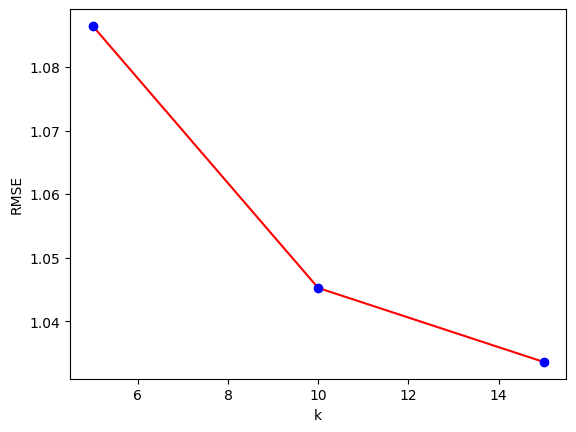

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

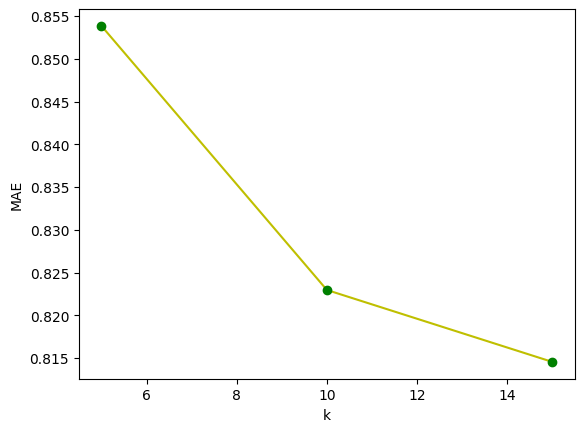

In [ ]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0864
MAE:  0.8538
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0453
MAE:  0.8230
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0232
MAE:  0.8060
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0205
MAE:  0.8053
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0206
MAE:  0.8063
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8090
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0250
MAE:  0.8131


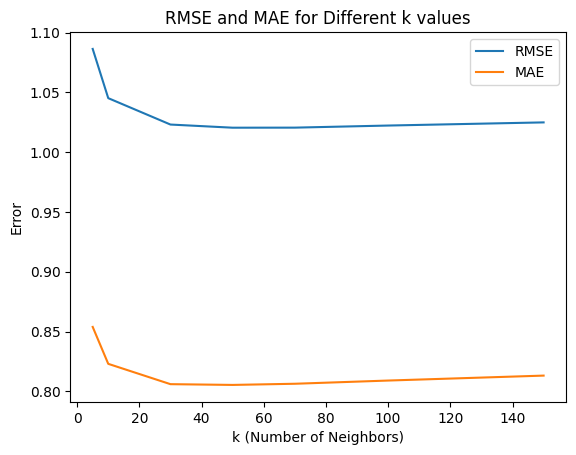

In [ ]:
from surprise import KNNBasic, accuracy

k_values = [5, 10, 30, 50, 70, 100, 150]  # definir distintos valores de vecinos (k)
mae_values = []
rmse_values = []

for k in k_values:
  myUserKnn = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))


plt.plot(k_values, rmse_values, label='RMSE')
plt.plot(k_values, mae_values, label='MAE')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Error')
plt.title('RMSE and MAE for Different k values')
plt.legend()
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1904
MAE:  0.9387
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1081
MAE:  0.8727
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0468
MAE:  0.8240
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0363
MAE:  0.8167
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0342
MAE:  0.8172
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0358
MAE:  0.8220
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0406
MAE:  0.8306


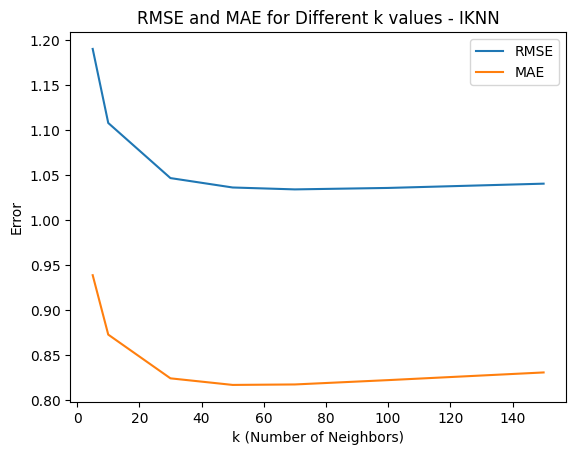

In [ ]:
k_values = [5, 10, 30, 50, 70, 100, 150]  # definir distintos valores de vecinos (k)
mae_values = []  # para almacenar resultados de MAE
rmse_values = []  # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False}) #Aqui se declara que no queremos UKNN sino IKNN
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))


plt.plot(k_values, rmse_values, label='RMSE')
plt.plot(k_values, mae_values, label='MAE')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Error')
plt.title('RMSE and MAE for Different k values - IKNN')
plt.legend()
plt.show()



## Factorización Matricial

La **factorización matricial** busca aproximar la matriz de calificaciones $R$ mediante el producto de dos matrices de menor dimensión:

$$
R \approx P \cdot Q^T
$$

Donde:

* $R$ → matriz de calificaciones (usuarios × ítems).
* $P$ → matriz de vectores latentes de usuarios (usuarios × factores).
* $Q$ → matriz de vectores latentes de ítems (ítems × factores).
* $k$ → número de factores latentes.

---

## Entrenamiento con SGD

Se inicializan $P$ y $Q$ aleatoriamente y se ajustan para minimizar:

$$
\min_{P,Q} \sum_{(u,i) \in \text{ratings}} (R_{ui} - P_u \cdot Q_i)^2 + \beta (||P||^2 + ||Q||^2)
$$

Mediante **descenso de gradiente estocástico (SGD)**:

1. Para cada calificación conocida, calcular el error:

   $$
   e_{ui} = R_{ui} - P_u \cdot Q_i
   $$
2. Actualizar:

   $$
   P_u \leftarrow P_u + \alpha (e_{ui} Q_i - \beta P_u)
   $$

   $$
   Q_i \leftarrow Q_i + \alpha (e_{ui} P_u - \beta Q_i)
   $$

---

* **Matriz P:** vectores latentes de cada usuario.
* **Matriz Q:** vectores latentes de cada ítem.
* **Matriz reconstruida $R_{\text{hat}}$:** predicciones para todos los pares usuario–ítem, incluyendo los del anti-test set.

Con estas predicciones, se ordenan los ítems del anti-test set por puntuación descendente para generar las recomendaciones.


In [ ]:
import numpy as np
import pandas as pd

R = np.array([
    [5, 5, 1, 4, 0],  # nicolas
    [2, 2, 1, 0, 0],  # raquel
    [0, 0, 5, 0, 0],  # rene
    [2, 2, 0, 1, 0],  # eleazar
    [5, 5, 1, 0, 0]   # sara
], dtype=float)

users = ["nicolas", "raquel", "rene", "eleazar", "sara"]
items = ["anora", "la_sustancia", "emilia_perez", "flow", "conclave"]

print("📊 Matriz original (R):")
display(pd.DataFrame(R, index=users, columns=items))


np.random.seed(42)
num_users, num_items = R.shape
k = 2

P = np.random.rand(num_users, k)
Q = np.random.rand(num_items, k)

alpha = 0.01  # tasa de aprendizaje
beta = 0.02   # regularización
epochs = 5000

for _ in range(epochs):
    for u in range(num_users):
        for i in range(num_items):
            if R[u, i] > 0:  # solo en ratings conocidos
                # Error de predicción
                e_ui = R[u, i] - np.dot(P[u, :], Q[i, :])
                # Actualización de vectores
                P[u, :] += alpha * (e_ui * Q[i, :] - beta * P[u, :])
                Q[i, :] += alpha * (e_ui * P[u, :] - beta * Q[i, :])

print("\n🔹 Matriz P (vectores de usuarios):")
display(pd.DataFrame(P, index=users, columns=[f"f{j+1}" for j in range(k)]))

print("\n🔹 Matriz Q (vectores de ítems):")
display(pd.DataFrame(Q, index=items, columns=[f"f{j+1}" for j in range(k)]))

# Reconstrucción de la matriz R aproximada
R_hat = np.dot(P, Q.T)
print("\n🔹 Matriz reconstruida (R_hat):")
display(pd.DataFrame(R_hat, index=users, columns=items))

📊 Matriz original (R):


,anora,la_sustancia,emilia_perez,flow,conclave
nicolas,5.0,5.0,1.0,4.0,0.0
raquel,2.0,2.0,1.0,0.0,0.0
rene,0.0,0.0,5.0,0.0,0.0
eleazar,2.0,2.0,0.0,1.0,0.0
sara,5.0,5.0,1.0,0.0,0.0



🔹 Matriz P (vectores de usuarios):


,f1,f2
nicolas,0.603346,2.243200
raquel,0.618768,0.732720
rene,3.145254,0.491072
eleazar,0.850082,0.624177
sara,0.614405,2.234733



🔹 Matriz Q (vectores de ítems):


,f1,f2
anora,0.863492,1.985112
la_sustancia,0.862772,1.985127
emilia_perez,1.574271,0.020594
flow,-0.095644,1.790136
conclave,0.431945,0.291229



🔹 Matriz reconstruida (R_hat):


,anora,la_sustancia,emilia_perez,flow,conclave
nicolas,4.973988,4.973589,0.996026,3.957926,0.913898
raquel,1.988833,1.988399,0.989198,1.252487,0.480663
rene,3.690735,3.688478,4.961595,0.578260,1.501591
eleazar,1.973100,1.972498,1.351114,1.036056,0.548967
sara,4.966728,4.966321,1.013262,3.941710,0.916209


In [ ]:
from surprise import SVD

algo = SVD()
algo.fit(trainset)
predictions_SVD = algo.test(testset)
RMSE_SVD = accuracy.rmse(predictions_SVD)
MAE_SVD = accuracy.mae(predictions_SVD)

RMSE: 0.9382
MAE:  0.7371
